In [1]:
import numpy as np, glob,os,cdtime
from itertools import combinations
import scipy.linalg, cdutil
import cdms2 as cdms, numpy as N
import MV2 as MV
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
import conda
conda_file_dir = conda.__file__
conda_dir = conda_file_dir.split('lib')[0]
proj_lib = os.path.join(os.path.join(conda_dir, 'share'), 'proj')
os.environ["PROJ_LIB"] = proj_lib
from mpl_toolkits.basemap import Basemap, shiftgrid, cm
from scipy import stats
import pymannkendall as mk

cdms.setNetcdfShuffleFlag(0)
cdms.setNetcdfDeflateFlag(0)
cdms.setNetcdfDeflateLevelFlag(0)


In [2]:
dicleb={1:'a',2:'b',3:'c',4:'d',5:'e',6:'f',7:'g',8:'h',9:'i',10:'j',11:'k',12:'l'}
def fiting(v,typeof):
 X,Y=N.zeros(v.shape),N.zeros(v.shape)
 for ii in range(v.shape[0]):
  if typeof=='Evap':X[ii,:]=ii*7/50.+7/100. # Evap between 0 and 7 (50 intervals)
  if typeof=='Snow':X[ii,:]=ii*2+1.   # snow between 0 and 100 (50 intervals)
  Y[:,ii]=ii*460/50.+460/100. # Solar radiation between 0 and 460 (50 intervals)
 print Y

 if typeof=='Evap':
   v=MV.masked_equal(v[10:,:-10],0)
   msk=v/v
   x=(X[10:,:-10]*msk).compressed()
   y=(Y[10:,:-10]*msk).compressed()
 else:
   v=MV.masked_equal(v,0)
   msk=v/v
   x=(X*msk).compressed()
   y=(Y*msk).compressed()    
 v=v.compressed()
 x = x.tolist()#[1.2, 1.3, 1.6, 2.5, 2.3, 2.8]
 y = y.tolist()#[167.0, 180.3, 177.8, 160.4, 179.6, 154.3]
 v=v.tolist()
 f = np.array(v).transpose()
 G = np.c_[x, y]
 #A = np.concatenate((G, np.ones((G.shape[0],1))), axis=1)
 #C, _, _, _ = scipy.linalg.lstsq(A, f)
 # C will have now the coefficients for:
 # f(x, y, z) = ax + by + cz + d
 # quadratic eq.
 dim = G.shape[1]
 #A = np.concatenate((G**2, np.array([np.prod(G[:, k], axis=1) for k in combinations(range(dim), dim-1)]).transpose(), G, np.ones((G.shape[0], 1))), axis=1)
 A = np.concatenate((G**2, np.expand_dims(G[:, 0]*G[:, 1],axis=1), G, np.ones((G.shape[0], 1))), axis=1)
 C, _, _, _ = scipy.linalg.lstsq(A, f)
 # C will have now the coefficients for:
 # f(x, y) = C[0]x**2 + C[1]y**2 + C[2]xy+ C[3]x + C[4]y + C[5]
 V=C[0]*X**2 + C[1]*Y**2 + C[2]*X*Y+ C[3]*X + C[4]*Y + C[5]
 return V,C

f=cdms.open('Snow_SWdown_sensitivity.nc')
v1=f('meandT_dLai')
f.close()

f=cdms.open('Evap_SWdown_sensitivity_logLAI.nc')
v2=f('meandT_dLai')
f.close()

V1,C1=fiting(v1.transpose(),'Snow')

V2,C2=fiting(v2.transpose(),'Evap')
V2=MV.where(V2>0,0,V2)

def dT_function(laiSE_,lai_,swd_,evap_,snc_,ratio_E=1.):
  lai_log=MV.masked_equal(laiSE_,0) # no veget beophysical impact if lai is constent 
  lai_log=N.log(lai_log+0.5)-N.log(lai_log-0.5) # because of having log function in the evap sensitivity 
  evap_=evap_*86400.# from kg/m2/s to mm/day
  evap_=MV.where(evap_<0.,0.,evap_) # normaly it never happen but in case of negative evap
  # dT/dLai = C[0]x**2 + C[1]y**2 + C[2]xy+ C[3]x + C[4]y + C[5]
  dT_dLAI=C2[0]*evap_*evap_ + C2[1]*swd_*swd_ + C2[2]*evap_*swd_+ C2[3]*evap_ + C2[4]*swd_ + C2[5]
  dT_dLAI=dT_dLAI*lai_log*ratio_E
  dT_dLAI=MV.where(dT_dLAI>0,0,dT_dLAI)# normaly it never happen for evap but in case of extrapolation to negative numbers because the model is not forced to 0
  # snow equ : x=snc, y=rsds
  dT_dLAI_snow=C1[0]*snc_*snc_ + C1[1]*swd_*swd_ + C1[2]*snc_*swd_+ C1[3]*snc_ + C1[4]*swd_ + C1[5]
  dT_dLAI=MV.where(snc_>1,dT_dLAI_snow,dT_dLAI) #if snow cover >1%
  dT_=dT_dLAI*(lai_-laiSE_)*land_mask
  dT_=cdms.createVariable(dT_,fill_value = 1.e+20,dtype='f',axes =lai_.getAxisList())
  dT_=toannual(cdutil.averager(dT_, axis='yx',weights='generate'))
  return dT_

def dT_function3D(laiSE_,lai_,swd_,evap_,snc_,ratio_E=1.,sensitivity=False):
  lai_log=MV.masked_equal(laiSE_,0) # no veget beophysical impact if lai is constent 
  lai_log=N.log(lai_log+0.5)-N.log(lai_log-0.5) # because of having log function in the evap sensitivity
  evap_=evap_*86400.# from kg/m2/s to mm/day
  evap_=MV.where(evap_<0.,0.,evap_) # normaly it never happen but in case of negative evap
  # dT/dLai = C[0]x**2 + C[1]y**2 + C[2]xy+ C[3]x + C[4]y + C[5]
  dT_dLAI=C2[0]*evap_*evap_ + C2[1]*swd_*swd_ + C2[2]*evap_*swd_+ C2[3]*evap_ + C2[4]*swd_ + C2[5]
  dT_dLAI=dT_dLAI*lai_log*ratio_E
  dT_dLAI=MV.where(dT_dLAI>0,0,dT_dLAI)# normaly it never happen for evap but in case of negative numbers due to interpolation problem
  # snow equ : x=snc, y=rsds
  dT_dLAI_snow=C1[0]*snc_*snc_ + C1[1]*swd_*swd_ + C1[2]*snc_*swd_+ C1[3]*snc_ + C1[4]*swd_ + C1[5]
  dT_dLAI=MV.where(snc_>1,dT_dLAI_snow,dT_dLAI)*land_mask #if snow cover >1%
  dT_=dT_dLAI*(lai_-laiSE_)
  dT_=cdms.createVariable(dT_,fill_value = 1.e+20,dtype='f',axes =lai_.getAxisList())
  dT_dLAI=cdms.createVariable(dT_dLAI,fill_value = 1.e+20,dtype='f',axes =lai_.getAxisList())
  if sensitivity:dT_=[dT_,dT_dLAI]
  return dT_

def toannual(tab_):
  annualy=tab_[0::12]/12.
  for mth in range(1,12,1):
    annualy=annualy+tab_[mth::12]/12.    
  return annualy
    
def repeat_first_yearsMean(tab_SE, tab_): # tab_SE is the mean saisonal cycle over 2003-2014
  tabout=N.zeros(tab_.shape)
  for i_ in range(tab_.shape[0]):
        tabout[i_,:,:]=tab_SE[i_%12,:,:]
  return tabout

latrange=(-56,80)
lonrange=(-180,180)

def readfile(fil_,var_):
  f=cdms.open(fil_)
  tab_=f(var_,lat=latrange,lon=lonrange,squeeze=1)
  f.close()
  return tab_

f=cdms.open('/ESS_Datasets/EXT_ESM/CMIP6/Historical/SE/seamask.nc')
land_mask=f('topo',lat=latrange,lon=lonrange)
f.close()

f=cdms.open('/home/alkamro/Desktop/world_conntries/world_grid_2deg.nc')
Greenland=MV.masked_equal(f('Band1',lat=latrange,lon=lonrange),77) # in order to mask Greenand
f.close()
land_mask=land_mask*Greenland/Greenland
land_mask=MV.masked_less(land_mask,0.5)
land_mask=land_mask/land_mask
f=cdms.open('/ESS_Datasets/EXT_ESM/CMIP6/Workdir/Trend/mask.nc') # mask arid with 0 m2/m2 LAI
mask=f('mask',lat=latrange,lon=lonrange)
f.close()
land_mask=land_mask*mask
        

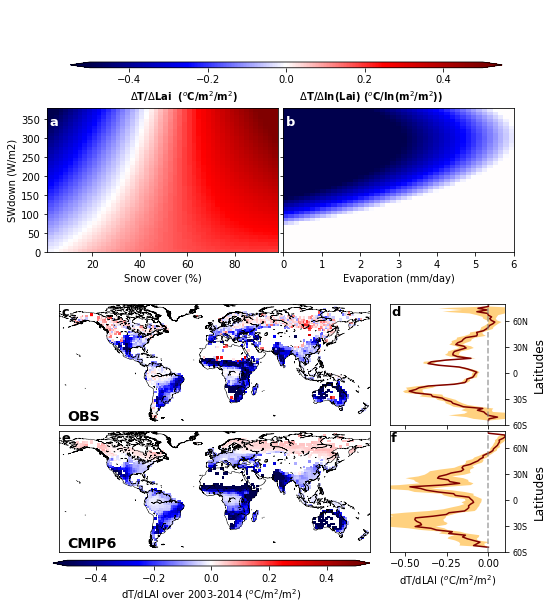

In [3]:
f=cdms.open('sensitivity_yearly.nc')
OBS=f('dT_dLAI')
f.close()

std=N.std(OBS,axis=0)
std=MV.masked_equal(std,0)
std=MV.masked_greater(std,0.3)

std=cdms.createVariable(std,fill_value = 1.e+20,dtype='f',axes =OBS[0,:,:].getAxisList())

std=std/std

if True:
 rsds_files=glob.glob("/ESS_Datasets/EXT_ESM/CMIP6/Historical/SE/rsds*")
 CMIP6=N.zeros((len(rsds_files),68,180))

 f=cdms.open('sensitivity_yearly.nc')
 OBS=f('dT_dLAI',lat=latrange,lon=lonrange)*std
 f.close()
 vvv=N.mean(OBS,axis=2) # to zonal
 vvv=MV.masked_greater(vvv,1.e10)
 Obsmin =N.percentile(vvv,10, axis=0)
 Obsmax =N.percentile(vvv,90, axis=0)
 Obsmedian =N.percentile(vvv,50, axis=0)
 OBSmean=N.mean(OBS,axis=0)
 #OBS=MV.masked_equal(OBS,0)
 ii=0
 for fil in rsds_files:
  model=fil[47:-6]
  print model
  f=cdms.open(fil)
  rsds=f('rsds',lat=latrange,lon=lonrange)
  f.close()
  for var in ['snc','evspsbl','lai']:
    filtmp=fil.replace('rsds',var)
    f=cdms.open(filtmp)
    vars()[var]=f(var,lat=latrange,lon=lonrange)
    f.close()
  lai=MV.masked_equal(lai,0)
  lai=N.log(lai+0.5)-N.log(lai-0.5)
  evspsbl=evspsbl*86400.# from kg/m2/s to mm/day
  evspsbl=MV.where(evspsbl<0.,0.,evspsbl) # normaly it never happen but in case of negative evap
  #print N.min(evspsbl.compressed()),N.max(evspsbl.compressed())
  # evap equ : x=evspsbl, y=rsds
  # dT/dLai = C[0]x**2 + C[1]y**2 + C[2]xy+ C[3]x + C[4]y + C[5]
  dT_dLAI=C2[0]*evspsbl*evspsbl + C2[1]*rsds*rsds + C2[2]*evspsbl*rsds+ C2[3]*evspsbl + C2[4]*rsds + C2[5]
  dT_dLAI=dT_dLAI*lai
  dT_dLAI=MV.where(dT_dLAI>0,0,dT_dLAI)# normaly it never happen but in case of extrapolation to negative numbers because the model is not forced to 0
  # snow equ : x=snc, y=rsds
  dT_dLAI_snow=C1[0]*snc*snc + C1[1]*rsds*rsds + C1[2]*snc*rsds+ C1[3]*snc + C1[4]*rsds + C1[5]
  #dT_dLAI_snow=MV.where(snc<1,0,dT_dLAI_snow)
  dT_dLAI=MV.where(snc>1,dT_dLAI_snow,dT_dLAI) #if biger than 1% snow cover
  dT_dLAI=cdms.createVariable(dT_dLAI*land_mask,fill_value = 1.e+20,dtype='f',axes =rsds.getAxisList())
  lons = dT_dLAI.getLongitude()[:]
  lats = dT_dLAI.getLatitude()[:]
  CMIP6[ii,:,:]=N.mean(dT_dLAI,axis=0)[:,:] # to annual
  ii=ii+1

 CMIP6=MV.masked_equal(CMIP6,0) # mask oceans =0 
 vvv=N.mean(CMIP6,axis=2) # to zonal
 Simmin =N.percentile(vvv,10, axis=0)
 Simmax =N.percentile(vvv,90, axis=0)
 Simmedian =N.percentile(vvv,50, axis=0)
 CMIP6mean=N.mean(CMIP6, axis=0)
 CMIP6mean=MV.masked_equal(CMIP6mean,0)
 CMIP6mean=CMIP6mean*(OBSmean+9)/(OBSmean+9)
 #N.percentile(CMIP6mean,50, axis=0)
 X1,Y1=0.1,0.11

 fig=plt.figure(figsize=(8,8))
 for ii in [5,7]:
    if ii==1:X1,Y1=0.1,0.77
    if ii==3:X1,Y1=0.1,0.55
    if ii==5:X1,Y1=0.1,0.33
    if ii==7:X1,Y1=0.1,0.11
    ax = fig.add_axes([X1,Y1,0.6,0.21])
    m = Basemap(projection='cyl',lon_0=0,resolution='l',llcrnrlon=-180., llcrnrlat=-60,
            urcrnrlon=180, urcrnrlat=80)
    m.drawcoastlines(linewidth=0.5)
    #m.drawmapboundary(fill_color='aqua')
    #m.drawcountries()
    #m.drawmapboundary(fill_color='grey')
    if ii==5:
      Vout50=OBSmean
      Vout50=MV.masked_equal(Vout50,0)
      Vout50=MV.masked_greater(Vout50,1.e10)
      plt.text(-170,-55,'OBS',fontsize=14,fontweight='bold')
      im = m.pcolormesh(lons,lats,Vout50,shading='flat',cmap=plt.cm.seismic,latlon=True,vmax=0.5,vmin=-0.5)#,vma
    else:
      Vout50=CMIP6mean
      im = m.pcolormesh(lons,lats,Vout50,shading='flat',cmap=plt.cm.seismic,latlon=True,vmax=0.5,vmin=-0.5)
    if ii==1: plt.text(-170,-55,'Obs',fontsize=14,fontweight='bold')
    plt.subplots_adjust(hspace = 0.02,wspace=0.02)
    if ii==7:
      plt.text(-170,-55,'CMIP6',fontsize=14,fontweight='bold')
      fig.subplots_adjust(bottom=0.05)
      cbar_ax = fig.add_axes([0.12, 0.085, 0.55, 0.01])
      cbar=fig.colorbar(im, cax=cbar_ax,orientation='horizontal', extend='both')
      #cbar_ax = fig.add_axes([0.8, 0.1, 0.01, 0.7])
      #cbar=fig.colorbar(im, cax=cbar_ax,orientation='vertical')
      cbar.set_label(r'dT/dLAI over 2003-2014 ($^o$C/m$^2$/m$^2$)',fontsize=10)
    ii=ii+1
    if ii==2:X1,Y1=0.705,0.77
    if ii==4:X1,Y1=0.705,0.55
    if ii==6:X1,Y1=0.705,0.33
    if ii==8:X1,Y1=0.705,0.11
    ax.text(0.01, 0.99, dicleb[ii-3], verticalalignment='top', horizontalalignment='left', transform=ax.transAxes, color='black', fontsize=13,fontweight='bold')  
    ax = fig.add_axes([X1,Y1,0.2,0.21])
    ax.text(0.01 , 0.99, dicleb[ii-2], verticalalignment='top', horizontalalignment='left', transform=ax.transAxes, color='black', fontsize=13,fontweight='bold')  

    yaxe  = lats
    if ii==6:
      ax.fill_betweenx(yaxe, Obsmin, Obsmax,facecolor='orange',alpha=0.5,lw=0)
      ax.plot(Obsmedian,yaxe.tolist(), 'maroon' , linewidth=1.5)
      ax.set_ylabel('Latitudes',fontsize=12)
    else:
      ax.fill_betweenx(yaxe, Simmin, Simmax,facecolor='orange',alpha=0.5,lw=0)
      ax.plot(Simmedian,yaxe.tolist(), 'maroon' , linewidth=1.5)
      ax.set_ylabel('Latitudes',fontsize=12)
    ax.yaxis.tick_right()
    ax.yaxis.set_major_locator(MultipleLocator(30))
    #ax.xaxis.set_major_locator(MultipleLocator(0.2))
    setoff=ax.get_yticks().tolist()
    for nn in range(len(setoff)): 
      if setoff[nn]<-0.1:
        setoff[nn]=str(abs(int( setoff[nn])))+'S'
      elif setoff[nn]>0.1:
        setoff[nn]=str(int( setoff[nn]))+'N'
      else:
        setoff[nn]='0'
    ax.set_yticklabels(setoff,fontsize=8)
    ax.yaxis.tick_right()
    ax.yaxis.set_label_coords(1.35, 0.5)
    #plt.xlim((-0.25, 1.5))
    plt.ylim((-60, 80))
    plt.xlim((-0.59, 0.1))
    plt.plot([0,0],[-60,80], linestyle ='--',color='grey',alpha=0.7)
    if ii!=8:
      setoff=ax.get_xticks().tolist()
      for nn in range(len(setoff)):
        setoff[nn]=''
      ax.set_xticklabels(setoff)
    else:
      ax.set_xlabel(r'dT/dLAI ($^o$C/m$^2$/m$^2$)',fontsize=10)
    
 ax=plt.axes([0.15,0.7,0.75,0.35])
 p = ax.pcolor(N.array([0,0]), N.array([0,0]),N.array([[0,0],[0,0]]), cmap=plt.cm.seismic, vmin=-0.5, vmax=0.5)
 cbaxes = fig.add_axes([0.15, 0.95, 0.75, 0.01]) 
 cbar = fig.colorbar(p, cax = cbaxes,ticks=[ -0.4,-0.2,0, 0.2,0.4],orientation='horizontal',shrink=0.9, extend='both')
 cbar.set_label(r'$\Delta$T/$\Delta$Lai  ($^o$C/m$^2$/m$^2$)                  $\Delta$T/$\Delta$ln(Lai) ($^o$C/ln(m$^2$/m$^2$))',fontsize=10,fontweight='bold')
 setoff=ax.get_yticks().tolist()
 for nn in range(len(setoff)):
    setoff[nn]=''

 ax.set_yticklabels(setoff)
 ax.set_xticklabels(setoff)
 ax.xaxis.set_major_locator(MultipleLocator(1000))
 ax.yaxis.set_major_locator(MultipleLocator(1000))
 ax.spines['top'].set_color('none')
 ax.spines['bottom'].set_color('none')
 ax.spines['right'].set_color('none')
 ax.spines['left'].set_color('none')

 ax = plt.axes([0.11,0.63,0.4,0.25])
 p = ax.pcolor(N.arange(0,100,2),N.arange(0,460,9.3), V1.transpose(), cmap=plt.cm.seismic, vmin=-0.3, vmax=0.3)
 ax.xaxis.set_major_locator(MultipleLocator(20))
 ax.yaxis.set_major_locator(MultipleLocator(50))
 #plt.plot([0,100],[0,100], linestyle ='--',color='black')
 plt.axis([1, 98, 1, 380])
 ax.set_xlabel('Snow cover (%)')
 ax.set_ylabel('SWdown (W/m2)')
 ax.text(0.01, 0.95, 'a', verticalalignment='top', horizontalalignment='left', transform=ax.transAxes, color='white', fontsize=13,fontweight='bold')  

 ax = plt.axes([0.52,0.63,0.4,0.25])
 p = ax.pcolor(N.arange(0,7,0.14), N.arange(0,460,9.3), V2.transpose(), cmap=plt.cm.seismic, vmin=-0.3, vmax=0.3)
 ax.xaxis.set_major_locator(MultipleLocator(1))
 ax.yaxis.set_major_locator(MultipleLocator(50))
 #plt.plot([0,100],[0,100], linestyle ='--',color='black')
 plt.axis([0, 6, 1, 380])
 ax.set_xlabel('Evaporation (mm/day)')
 #ax.set_ylabel('SWdown (W/m2)')
 setoff=ax.get_yticks().tolist()
 for nn in range(len(setoff)):
  setoff[nn]=''
 ax.set_yticklabels(setoff)
 ax.text(0.01, 0.95, 'b', verticalalignment='top', horizontalalignment='left', transform=ax.transAxes, color='white', fontsize=13,fontweight='bold')  

plt.savefig('Figure_01.pdf', dpi=300, bbox_inches="tight")




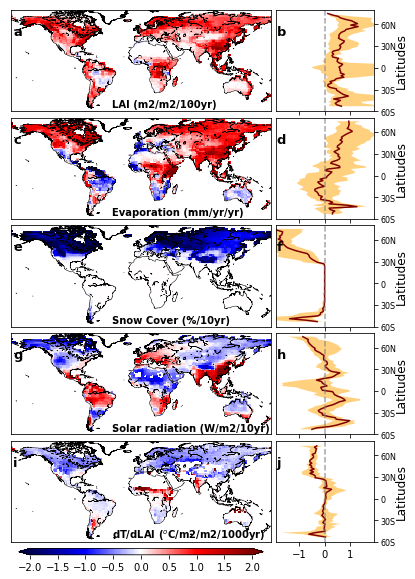

In [4]:
"""

Compute sensitivity change between 2100 and 2015 from CMIP6
and plot trends as shown in Fig. 2

"""

latrange=(-60,80)
lonrange=(-180,180)

def readfile(fil_,var_):
  f=cdms.open(fil_)
  tab_=f(var_,lat=latrange,lon=lonrange,squeeze=1)
  f.close()
  return tab_

f=cdms.open('/ESS_Datasets/EXT_ESM/CMIP6/Historical/SE/seamask.nc')
land_mask=f('topo',lat=latrange,lon=lonrange)
f.close()

f=cdms.open('/home/alkamro/Desktop/world_conntries/world_grid_2deg.nc')
Greenland=MV.masked_equal(f('Band1',lat=latrange,lon=lonrange),77)
f.close()
land_mask=land_mask*Greenland/Greenland
land_mask=MV.masked_less(land_mask,0.5)
land_mask=land_mask/land_mask
f=cdms.open('/ESS_Datasets/EXT_ESM/CMIP6/Workdir/Trend/mask.nc') # mask arid with 0 m2/m2 LAI
mask=f('mask',lat=latrange,lon=lonrange)
f.close()
land_mask=land_mask*mask


#  -----------------------------------------------------------------------

def Ttimax(nbfiles):
  # - creation axe des Temps
  tab=N.arange(1,nbfiles+1,1)
  timax = cdms.createAxis(tab,id='time')
  timax.long_name = 'Time'
  timax.units = 'days since 2000-01-01 00:00:00'
  timax.designateTime(calendar=cdtime.MixedCalendar)
  return timax

f=cdms.open('/ESS_Datasets/EXT_ESM/CMIP6/Historical/SE/seamask.nc')
land_mask=f('topo',lat=latrange,lon=lonrange)*land_mask
f.close()
f=cdms.open('/home/alkamro/Desktop/world_conntries/world_grid_2deg.nc')
Greenland=MV.masked_equal(f('Band1',lat=latrange,lon=lonrange),77)
f.close()
land_mask=land_mask*Greenland/Greenland
land_mask=MV.masked_less(land_mask,0.5)
land_mask=land_mask/land_mask
dic={'lai':'LAI (m2/m2/100yr)','evspsbl':'Evaporation (mm/yr/yr)','snc':'Snow Cover (%/10yr)','rsds':'Solar radiation (W/m2/10yr)',
     'dtPERdlai':'dT/dLAI ($^o$C/m2/m2/1000yr)'}

for ssp in [585]:#[126,245,370,585]:
  fig=plt.figure(figsize=(6.8,8.8))
  ii=1
  for var in ['lai','evspsbl','snc','rsds','dtPERdlai']:
    list_files=glob.glob("/ESS_Datasets/EXT_ESM/CMIP6/Workdir/Trend/%s*ssp%i*"%(var,ssp))
    TOT=N.zeros((len(list_files),70,180))
    caca=0
    for fil in list_files:
      f=cdms.open(fil)
      v=f(var,lat=(-60,80),squeeze=1)*land_mask
      lons = v.getLongitude()[:]
      lats = v.getLatitude()[:]
      v=N.ma.masked_invalid(v)

      if var =='lai':v=v*100
      if var =='snc' or var =='rsds':v=v*10
      if var =='dtPERdlai':
        v=v*10/0.9
        #v=N.ma.masked_invalid(MV.masked_greater(v,1))
      if var =='evspsbl':v=v*86400.*365.25 # kg/m2/s/yr to mm/yr2
      f.close()
      TOT[caca,:,:]=N.ma.masked_invalid(v[:,:])
      caca=caca+1
    timax=Ttimax(len(list_files))
    TOT=MV.masked_greater(TOT,1e10)
    TOT=cdms.createVariable(TOT,fill_value = 1.e+20,dtype='f',axes =[timax,v.getLatitude(),v.getLongitude()])
    TOT=TOT*land_mask
    TOT=cdms.createVariable(TOT,fill_value = 1.e+20,dtype='f',axes =[timax,v.getLatitude(),v.getLongitude()])
    median2D=MV.masked_greater(N.percentile(TOT,50, axis=0)*land_mask,1.e18)
    print median2D,N.min(median2D),N.max(median2D) 
    if ii==1:X1,Y1=0.1,0.82#0.77
    if ii==3:X1,Y1=0.1,0.82-0.17#0.55
    if ii==5:X1,Y1=0.1,0.82-0.17*2#0.33
    if ii==7:X1,Y1=0.1,0.82-0.17*3#0.11
    if ii==9:X1,Y1=0.1,0.82-0.17*4

    ax = fig.add_axes([X1,Y1,0.6,0.21-0.05])
    ax.text(0.01, 0.85, dicleb[ii], verticalalignment='top', horizontalalignment='left', transform=ax.transAxes, color='k', fontsize=13,fontweight='bold')  
    m = Basemap(projection='cyl',lon_0=0,resolution='l',llcrnrlon=-180., llcrnrlat=-60,
            urcrnrlon=180, urcrnrlat=80)
    m.drawcoastlines(linewidth=0.5)
    #m.drawcountries()
    im = m.pcolormesh(lons,lats,median2D,shading='flat',cmap=plt.cm.seismic,latlon=True,vmax=2,vmin=-2)#,vmax=0.01,vmin=-0.01)
    plt.text(-40,-55,r'%s'%dic[var],fontsize=10,fontweight='bold')
    #plt.text(-10,62,'%i-%i'%(yrdeb,yrfin),fontsize=16,fontweight='bold')
    plt.subplots_adjust(hspace = 0.02,wspace=0.02)

    if var=='rsds':
      fig.subplots_adjust(bottom=0.05)
      cbar_ax = fig.add_axes([0.15, 0.12, 0.5, 0.01])
      cbar=fig.colorbar(im, cax=cbar_ax,orientation='horizontal', extend='both')
    ii=ii+1
    if ii==2:X1,Y1=0.705,0.82#0.77
    if ii==4:X1,Y1=0.705,0.82-0.17#0.55
    if ii==6:X1,Y1=0.705,0.82-0.17*2#0.33
    if ii==8:X1,Y1=0.705,0.82-0.17*3#0.11
    if ii==10:X1,Y1=0.705,0.82-0.17*4

    yaxe=lats
    ax = fig.add_axes([X1-0.03,Y1,0.2,0.21-0.05])
    ax.text(0.01, 0.85, dicleb[ii], verticalalignment='top', horizontalalignment='left', transform=ax.transAxes, color='black', fontsize=13,fontweight='bold')  
    VT=cdutil.averager(TOT,axis='2',weights='equal', action='average')
    VTmin =MV.masked_equal(N.percentile(VT,10, axis=0),0)
    VTmax =MV.masked_equal(N.percentile(VT,90, axis=0),0)
    VTmean=MV.masked_equal(N.percentile(VT,50, axis=0),0)
    VTmin=VTmin*VTmax/VTmax
    VTmax=VTmax*VTmin/VTmin
    ax.fill_betweenx((yaxe*VTmin/VTmin).compressed(), VTmin.compressed(), VTmax.compressed(),facecolor='orange',alpha=0.5,lw=0)
    yaxe=(yaxe*VTmean/VTmean).compressed()
    ax.plot(VTmean.compressed(),yaxe.tolist(), 'maroon' , linewidth=1.5)
    ax.set_ylabel('Latitudes',fontsize=12)
   
    ax.yaxis.tick_right()
    ax.yaxis.set_major_locator(MultipleLocator(30))
    ax.xaxis.set_major_locator(MultipleLocator(1))
    setoff=ax.get_yticks().tolist()
    yyfirst=[-60]
    yyfirst.extend(setoff[:-1])
    setoff=yyfirst
    for nn in range(len(setoff)): 
      if setoff[nn]<-0.1:
        setoff[nn]=str(abs(int( setoff[nn])))+'S'
      elif setoff[nn]>0.1:
        setoff[nn]=str(int( setoff[nn]))+'N'
      else:
        setoff[nn]='0'
    ax.set_yticklabels(setoff,fontsize=8)
    ax.yaxis.tick_right()
    ax.yaxis.set_label_coords(1.35, 0.5)
    plt.xlim((-1.9, 1.9))
    plt.ylim((-60, 80))
    plt.plot([0,0],[-60,80], linestyle ='--',color='grey',alpha=0.7)
    if var!='dtPERdlai':
      setoff=ax.get_xticks().tolist()
      for nn in range(len(setoff)):
        setoff[nn]=''
      ax.set_xticklabels(setoff)
    else:
      if var=='lai':ax.set_xlabel(r'LAI trend (m$^{2}$/m$^{2}$/decade)',fontsize=10)
      if var=='mrso': ax.set_xlabel(r'Soil moisture trend (10$^{-2}$ %/yr)',fontsize=8)
      if var=='snc': ax.set_xlabel(r'Snow cover trend (10$^{-1}$ %/yr)',fontsize=8)

    ii=ii+1
  plt.savefig('Figure_02.pdf', dpi=300, bbox_inches="tight")

In [5]:

Ratio_evap=True
list_models=[]

if not Ratio_evap:
  for ssp in [585,370,245,126]:
    vars()['BiophModels'+str(ssp)]=[]
    nfile=0
    files_dT_dLai=glob.glob('*_dT_dLAI_ssp%i_201501_210012.nc'%ssp)
    files_dT_dLai.sort() 
    for rr in ['dT_allBioph','dT_Bioph_ClimateConst','dT_Bioph_Climate','dT_Bioph_SWd','dT_Bioph_EVAP','dT_Bioph_SNC']:
        vars()[rr+str(ssp)]=N.zeros((len(files_dT_dLai),86))
        vars()[rr+str(ssp)+'slop']=[]
    for fil in files_dT_dLai:
        model=fil[:-32]
        eval('BiophModels'+str(ssp)).append(model)
        if not os.path.exists('/ESS_Datasets/EXT_ESM/CMIP6/Historical/SE/lai_%s_SE.nc'%model):
            print 'historical %s ssp%s does not exist, please download it'%(model,ssp)
        else:
            for vv in ['lai','snc','evspsbl','rsds']: # read SE historical files
                f=cdms.open('/ESS_Datasets/EXT_ESM/CMIP6/Workdir/%s_%s_ssp%i_201501-210012.nc'%(vv,model,ssp))
                vars()[vv]=f(vv,lat=latrange,lon=lonrange)
                f.close()
                f=cdms.open('/ESS_Datasets/EXT_ESM/CMIP6/Historical/SE/%s_%s_SE.nc'%(vv,model))
                vars()[vv+'0']=f(vv,lat=latrange,lon=lonrange)
                f.close()
                vars()[vv+'0']=repeat_first_yearsMean(eval(vv+'0'), eval(vv))  
            # 1) all Bioph
            dT_allBioph=dT_function(lai0,lai,rsds,evspsbl0,snc)
            # 2) Bioph but clim constant          
            dT_Bioph_ClimateConst=dT_function(lai0,lai,rsds0,evspsbl0,snc0)
            # 3) Bioph : part of clim change= all-clim constent
            dT_Bioph_Climate=dT_allBioph-dT_Bioph_ClimateConst
            # 4) clim constant except Solar radiation 
            dT_Bioph_SWd=dT_allBioph-dT_function(lai0,lai,rsds0,evspsbl,snc)#dT_function(lai0,lai,rsds,evspsbl0,snc0)-dT_Bioph_ClimateConst
            # 5) clim constant except evapotranspiration
            dT_Bioph_EVAP=dT_allBioph-dT_function(lai0,lai,rsds,evspsbl0,snc)#dT_function(lai0,lai,rsds0,evspsbl,snc0)-dT_Bioph_ClimateConst    
            # 6) clim constant except snow cover
            dT_Bioph_SNC=dT_allBioph-dT_function(lai0,lai,rsds,evspsbl,snc0)#dT_function(lai0,lai,rsds0,evspsbl0,snc)-dT_Bioph_ClimateConst   
            for rr in ['dT_allBioph','dT_Bioph_ClimateConst','dT_Bioph_Climate','dT_Bioph_SWd','dT_Bioph_EVAP','dT_Bioph_SNC']:
              trend, h, p, z, Tau, s, var_s, slope, intercept = mk.original_test(eval(rr)) 
              eval(rr+str(ssp)+'slop').append(slope*86) #86 years
              eval(rr+str(ssp))[nfile,:]=eval(rr)[:]
            nfile=nfile+1
else:
  for ssp in [585,370,245,126]:
    vars()['BiophModels'+str(ssp)]=[]
    nfile=0
    files_dT_dLai=glob.glob('*_dT_dLAI_ssp%i_201501_210012.nc'%ssp)
    files_dT_dLai.sort()
    for rr in ['dT_allBioph','dT_Bioph_ClimateConst','dT_Bioph_Climate','dT_Bioph_SWd','dT_Bioph_EVAP','dT_Bioph_SNC']:
        vars()[rr+str(ssp)]=N.zeros((len(files_dT_dLai),86))
        vars()[rr+str(ssp)+'slop']=[]
    for fil in files_dT_dLai:
        model=fil[:-32]
        eval('BiophModels'+str(ssp)).append(model)
        if not os.path.exists('/ESS_Datasets/EXT_ESM/CMIP6/Historical/SE/lai_%s_SE.nc'%model):
            print 'historical %s ssp%s does not exist, please download it'%(model,ssp)
        else:
            for vv in ['lai','snc','evspsbl','rsds']: # read SE historical files
                f=cdms.open('/ESS_Datasets/EXT_ESM/CMIP6/Workdir/%s_%s_ssp%i_201501-210012.nc'%(vv,model,ssp))
                vars()[vv]=f(vv,lat=latrange,lon=lonrange)
                f.close()
                f=cdms.open('/ESS_Datasets/EXT_ESM/CMIP6/Historical/SE/%s_%s_SE.nc'%(vv,model))
                vars()[vv+'0']=f(vv,lat=latrange,lon=lonrange)
                f.close()
                vars()[vv+'0']=repeat_first_yearsMean(eval(vv+'0'), eval(vv))  
            ratio_evap=MV.where(evspsbl0<=0.,1,evspsbl/evspsbl0)
            ratio_evap=MV.where(ratio_evap<0,0,ratio_evap)
            # 1) all Bioph
            dT_allBioph=dT_function(lai0,lai,rsds,evspsbl0,snc,ratio_evap)
            # 2) Bioph but clim constant          
            dT_Bioph_ClimateConst=dT_function(lai0,lai,rsds0,evspsbl0,snc0)
            # 3) Bioph : part of clim change= all-clim constent
            dT_Bioph_Climate=dT_allBioph-dT_Bioph_ClimateConst
            # 4) clim constant except Solar radiation 
            dT_Bioph_SWd=dT_allBioph-dT_function(lai0,lai,rsds0,evspsbl0,snc,ratio_evap)#dT_function(lai0,lai,rsds,evspsbl0,snc0)-dT_Bioph_ClimateConst
            # 5) clim constant except evapotranspiration
            dT_Bioph_EVAP=dT_allBioph-dT_function(lai0,lai,rsds,evspsbl0,snc)#dT_function(lai0,lai,rsds0,evspsbl,snc0)-dT_Bioph_ClimateConst    
            # 6) clim constant except snow cover
            dT_Bioph_SNC=dT_allBioph-dT_function(lai0,lai,rsds,evspsbl0,snc0,ratio_evap)#dT_function(lai0,lai,rsds0,evspsbl0,snc)-dT_Bioph_ClimateConst   
            for rr in ['dT_allBioph','dT_Bioph_ClimateConst','dT_Bioph_Climate','dT_Bioph_SWd','dT_Bioph_EVAP','dT_Bioph_SNC']:
              trend, h, p, z, Tau, s, var_s, slope, intercept = mk.original_test(eval(rr)) 
              eval(rr+str(ssp)+'slop').append(slope*86) #86 years
              eval(rr+str(ssp))[nfile,:]=eval(rr)[:]
            nfile=nfile+1

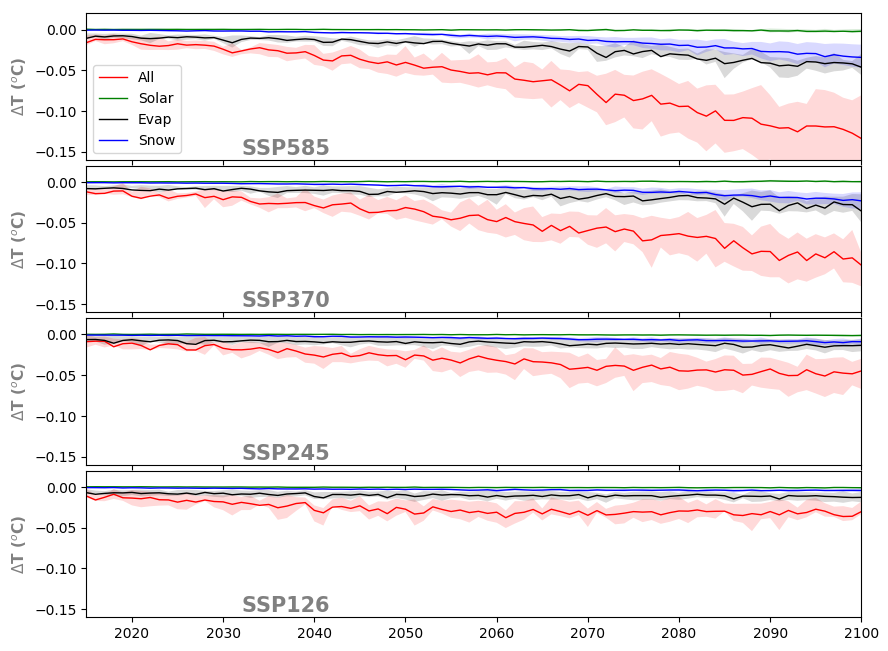

In [6]:
jj=1
YRS=range(2015,2101,1)
COLORS=['red','green','black','blue','orange','purple']
LABELS=['All','Solar','Evap','Snow']
fig = plt.figure(figsize=(10,8), dpi= 100, facecolor='w', edgecolor='k')
for ssp in [585,370,245,126]:
  ax = fig.add_subplot(4,1,jj)
  jj=jj+1
  ii=-1
  for rr in ['dT_allBioph','dT_Bioph_SWd','dT_Bioph_EVAP','dT_Bioph_SNC']:#,'dT_Bioph_ClimateConst','dT_Bioph_Climate']:
    ii=ii+1
    plt.fill_between(YRS, N.percentile(eval(rr+str(ssp)),25,axis=0), N.percentile(eval(rr+str(ssp)),75,axis=0),\
                     facecolor=COLORS[ii],  alpha=0.15,lw=0)

    plt.plot(YRS,N.mean(eval(rr+str(ssp)),axis=0), COLORS[ii]  , linewidth=1, label=LABELS[ii])

  ax.set_ylabel(r'$\Delta$T ($^o$C)',fontsize=11,fontweight='bold',color='grey')
  ax.set_xlim(2015, 2100)
  ax.set_ylim(-0.16,0.02)
  if jj==2 : 
    plt.legend()
  if jj<5 : 
    labels = [item.get_text() for item in ax.get_xticklabels()]
    labels[1 ] = ''
    labels[2 ] = ''
    labels[3 ] = ''
    labels[4 ] = ''
    labels[5 ] = ''
    labels[6 ] = ''
    labels[7 ] = ''
    labels[8 ] = ''
    labels[9 ] = ''
    ax.set_xticklabels(labels)

  plt.subplots_adjust(hspace = 0.04,wspace=0.001)
  ax.text(0.2, 0.01, 'SSP%i'%ssp, verticalalignment='bottom', horizontalalignment='left',
          transform=ax.transAxes, color='grey', fontsize=15,fontweight='bold') #verticalalignment='bottom', horizontalalignment='right'

plt.savefig('dT_timeseries.png')

In [7]:
# temp from LeDuc et al. 2016    https://www.nature.com/articles/nclimate2913
f=cdms.open('/workdir/DATA/BIOMASS/VOD/LeDuc_TCRE-mean-tas_CMIP5_2deg.nc')
T_Biogeochimical=-f('tas',lat=latrange,lon=lonrange,squeeze=1)*land_mask
f.close()
T_Biogeochimical=float(cdutil.averager(T_Biogeochimical, axis='yx',weights='generate'))
# carbon in vegetation
for ssp in ['ssp126','ssp245','ssp370','ssp585']:
  vars()['Biogeochimical_%s'%ssp]=[]
  vars()['BiogeochimicalModels%s'%ssp]=[]
  for fil in glob.glob("/run/media/alkamro/EXT_HD/Downloads/TMP/cVeg*_*%s*trend.nc"%ssp):
    model,gr=fil.split('_')[3],fil.split('_')[5]
    print model
    eval('BiogeochimicalModels'+str(ssp)).append(model)
    filarea='/run/media/alkamro/EXT_HD/Downloads/TMP/area_%s.nc'%model
    if  not os.path.exists(filarea):
      os.system("cdo gridarea %s %s"  %(fil,filarea))
    f=cdms.open(filarea)
    v=f('cell_area',squeeze=1)
    f.close()  
    f=cdms.open(fil)
    v=f('cVeg',squeeze=1)*v*(2100-2015+1)
    f.close()
    total=T_Biogeochimical*N.nansum(v.compressed())/1.e15 # from kgC to TtC
    eval('Biogeochimical_%s'%ssp).append(total)



In [8]:
# Simulated Temperature trend over land
for ssp in ['ssp126','ssp245','ssp370','ssp585']:
  vars()['Abs_%s'%ssp]=[]
  vars()['AbsModels%s'%ssp]=[]
  for fil in glob.glob("/ESS_Datasets/EXT_ESM/CMIP6/Workdir/Trend/tas_Amon*%s*12.nc"%ssp):
    model=fil.split('_')[4]
    eval('AbsModels'+str(ssp)).append(model)
    f=cdms.open(fil)
    v=f('tas',lat=latrange,lon=lonrange,squeeze=1)*land_mask*86
    f.close()       
    Total=float(cdutil.averager(v, axis='yx',weights='generate'))
    eval('Abs_%s'%ssp).append(Total)

def AbsToRelative(Models1,Models2,data1,data2):
    relative=[]
    res1 = dict(zip(Models1,data1))
    res2 = dict(zip(Models2,data2))
    for model in Models1:
        if model in Models2: 
            relative.append(100*res1[model]/res2[model])
    return relative
    
# bioph, and bioch  in relative term compared to simulated warming
for ssp in ['ssp126','ssp245','ssp370','ssp585']:
    SSP=int(ssp[3:])
    vars()['BiophRelative_%s'%ssp]=AbsToRelative(eval('BiophModels'+str(SSP)),eval('AbsModels%s'%ssp),eval('dT_allBioph'+str(SSP)+'slop'),eval('Abs_%s'%ssp))
    vars()['BiogeochimicalRelative_%s'%ssp]=AbsToRelative(eval('BiogeochimicalModels'+str(ssp)),eval('AbsModels%s'%ssp),eval('Biogeochimical_%s'%ssp),eval('Abs_%s'%ssp))


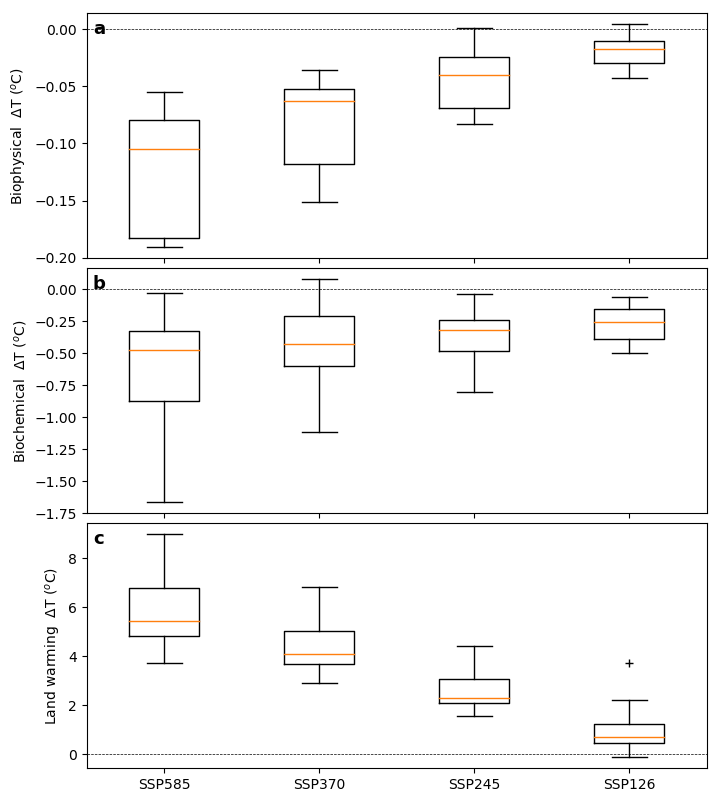

In [9]:
fig = plt.figure(figsize=(8,10), dpi= 100, facecolor='w', edgecolor='k')
BoxDataCH=[Biogeochimical_ssp585,Biogeochimical_ssp370,Biogeochimical_ssp245,Biogeochimical_ssp126]
BoxDataPH=[dT_allBioph585slop,dT_allBioph370slop,dT_allBioph245slop,dT_allBioph126slop]
BoxDataABS=[Abs_ssp585,Abs_ssp370,Abs_ssp245,Abs_ssp126]

BoxDataCHrelative=[BiogeochimicalRelative_ssp585, BiogeochimicalRelative_ssp370,\
                   BiogeochimicalRelative_ssp245, BiogeochimicalRelative_ssp126]
BoxDataPHrelative=[BiophRelative_ssp585,BiophRelative_ssp370,BiophRelative_ssp245,BiophRelative_ssp126]

print 'Bioph'
for vito in BoxDataPHrelative: 
    print N.mean(vito),N.std(vito)
 
print 'Biogeogemical'
for vito in BoxDataCHrelative: 
    print N.mean(vito),N.std(vito)
    
def figinfo():
    plt.setp(bp['boxes'], color='grey')
    plt.setp(bp['whiskers'], color='grey')
    plt.setp(bp['fliers'], color='grey', marker='+',markeredgecolor='grey')  
    plt.setp(bp['means'], color='grey')
    plt.setp(bp['medians'], color='grey')   
    plt.setp(bp['caps'], color='grey') 

ax = fig.add_subplot(3,1,1)
plt.plot([0.5,4.5],[0,0],color='black',linewidth=0.5, linestyle='dashed')
ax.set_ylabel(r'Biophysical  $\Delta$T ($^o$C)')
bp=plt.boxplot(BoxDataPH, sym='+', vert=1, whis=1.5)
figinfo
ax.text(0.01, 0.9, 'a', verticalalignment='bottom', horizontalalignment='left', transform=ax.transAxes, color='black', fontsize=13,fontweight='bold') 


ax = fig.add_subplot(3,1,2)
plt.plot([0.5,4.5],[0,0],color='black',linewidth=0.5, linestyle='dashed')
ax.set_ylabel(r'Biochemical  $\Delta$T ($^o$C)')
bp2=plt.boxplot(BoxDataCH, sym='+', vert=1, whis=1.5)
figinfo
ax.text(0.01, 0.9, 'b', verticalalignment='bottom', horizontalalignment='left', transform=ax.transAxes, color='black', fontsize=13,fontweight='bold') 
plt.subplots_adjust(hspace = 0.04,wspace=0.02)

#ax = fig.add_subplot(3,2,2)
#plt.plot([0.5,4.5],[0,0],color='black',linewidth=0.5, linestyle='dashed')
#ax.set_ylabel(r'Biophysical  $\Delta$T (%)')
#bp=plt.boxplot(BoxDataPHrelative, sym='+', vert=1, whis=1.5)
#figinfo
#ax.text(0.01, 0.9, 'd', verticalalignment='bottom', horizontalalignment='left', transform=ax.transAxes, color='black', fontsize=13,fontweight='bold') 
#ax.yaxis.set_label_position("right")
#ax.yaxis.tick_right()


ax = fig.add_subplot(3,1,3)
plt.plot([0.5,4.5],[0,0],color='black',linewidth=0.5, linestyle='dashed')
ax.set_ylabel(r'Land warming  $\Delta$T ($^o$C)')
bp2=plt.boxplot(BoxDataABS, sym='+', vert=1, whis=1.5)
figinfo
ax.xaxis.set_major_locator(MultipleLocator(1))
labels = [item.get_text() for item in ax.get_xticklabels()]
labels[1] = 'SSP585'
labels[2] = 'SSP370'
labels[3] = 'SSP245'
labels[4] = 'SSP126'
ax.set_xticklabels(labels)
ax.text(0.01, 0.9, 'c', verticalalignment='bottom', horizontalalignment='left', transform=ax.transAxes, color='black', fontsize=13,fontweight='bold') 


#ax = fig.add_subplot(3,2,4)
#plt.plot([0.5,4.5],[0,0],color='black',linewidth=0.5, linestyle='dashed')
#ax.set_ylabel(r'Biochimical  $\Delta$T (%)')
#bp2=plt.boxplot(BoxDataCHrelative, sym='+', vert=1, whis=1.5)
#figinfo
#ax.xaxis.set_major_locator(MultipleLocator(1))
#ax.text(0.01, 0.9, 'e', verticalalignment='bottom', horizontalalignment='left', transform=ax.transAxes, color='black', fontsize=13,fontweight='bold') 
#plt.subplots_adjust(hspace = 0.04,wspace=0.02)
#ax.set_xticklabels(labels)
#ax.yaxis.set_label_position("right")
#ax.yaxis.tick_right()
    
plt.savefig('Figure_05.pdf', dpi=300, bbox_inches="tight")

In [10]:
latrange=(-60,80)
for ssp in [585,370,245,126]:
    nfile=0
    files_dT_dLai=glob.glob('*_dT_dLAI_ssp%i_201501_210012.nc'%ssp)
    for rr in ['dT_allBioph','dT_Bioph_ClimateConst','dT_Bioph_Climate','dT_Bioph_SWd','dT_Bioph_EVAP','dT_Bioph_SNC']:
        vars()[rr+str(ssp)]=N.zeros((len(files_dT_dLai),86))
        vars()[rr+str(ssp)+'slop']=[]
    for fil in files_dT_dLai:
        model=fil[:-32]
        if not os.path.exists('/ESS_Datasets/EXT_ESM/CMIP6/Historical/SE/lai_%s_SE.nc'%model):
            print 'historical %s ssp%s does not exist, please download it'%(model,ssp)
        else:
            for vv in ['lai','snc','evspsbl','rsds']: # read SE historical files
                f=cdms.open('/ESS_Datasets/EXT_ESM/CMIP6/Workdir/%s_%s_ssp%i_201501-210012.nc'%(vv,model,ssp))
                vars()[vv]=f(vv,lat=latrange,lon=lonrange)
                f.close()
                f=cdms.open('/ESS_Datasets/EXT_ESM/CMIP6/Historical/SE/%s_%s_SE.nc'%(vv,model))
                vars()[vv+'0']=f(vv,lat=latrange,lon=lonrange)
                f.close()
                vars()[vv+'0']=repeat_first_yearsMean(eval(vv+'0'), eval(vv))  
            ratio_evap=MV.where(evspsbl0<=0.,1,evspsbl/evspsbl0)
            ratio_evap=MV.where(ratio_evap<0,0,ratio_evap)
            # 1) all Bioph
            dT_allBioph=dT_function(lai0,lai,rsds,evspsbl0,snc,ratio_evap)
            # 2) Bioph but clim constant          
            dT_Bioph_ClimateConst=dT_function(lai0,lai,rsds0,evspsbl0,snc0)
            # 3) Bioph : part of clim change= all-clim constent
            dT_Bioph_Climate=dT_allBioph-dT_Bioph_ClimateConst
            # 4) clim constant except Solar radiation 
            dT_Bioph_SWd=dT_allBioph-dT_function(lai0,lai,rsds0,evspsbl0,snc,ratio_evap)#dT_function(lai0,lai,rsds,evspsbl0,snc0)-dT_Bioph_ClimateConst
            # 5) clim constant except evapotranspiration
            dT_Bioph_EVAP=dT_allBioph-dT_function(lai0,lai,rsds,evspsbl0,snc)#dT_function(lai0,lai,rsds0,evspsbl,snc0)-dT_Bioph_ClimateConst    
            # 6) clim constant except snow cover
            dT_Bioph_SNC=dT_allBioph-dT_function(lai0,lai,rsds,evspsbl0,snc0,ratio_evap)#dT_function(lai0,lai,rsds0,evspsbl0,snc)-dT_Bioph_ClimateConst   
            for rr in ['dT_allBioph','dT_Bioph_ClimateConst','dT_Bioph_Climate','dT_Bioph_SWd','dT_Bioph_EVAP','dT_Bioph_SNC']:
              trend, h, p, z, Tau, s, var_s, slope, intercept = mk.original_test(eval(rr)) 
              eval(rr+str(ssp)+'slop').append(slope*86) #86 years
              eval(rr+str(ssp))[nfile,:]=eval(rr)[:]
            nfile=nfile+1

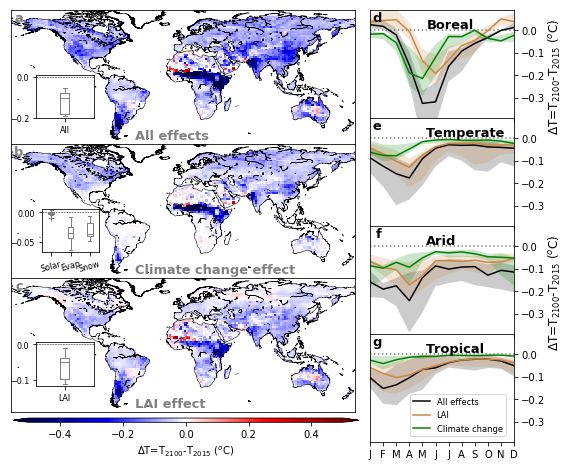

In [11]:
latrange=(-56,80)
lonrange=(-180,180)

def readfile(fil_,var_):
  f=cdms.open(fil_)
  tab_=f(var_,lat=latrange,lon=lonrange,squeeze=1)
  f.close()
  return tab_

f=cdms.open('/ESS_Datasets/EXT_ESM/CMIP6/Historical/SE/seamask.nc')
land_mask=f('topo',lat=latrange,lon=lonrange)
f.close()

f=cdms.open('/home/alkamro/Desktop/world_conntries/world_grid_2deg.nc')
Greenland=MV.masked_equal(f('Band1',lat=latrange,lon=lonrange),77) # in order to mask Greenand
f.close()
land_mask=land_mask*Greenland/Greenland
land_mask=MV.masked_less(land_mask,0.5)
land_mask=land_mask/land_mask
f=cdms.open('/ESS_Datasets/EXT_ESM/CMIP6/Workdir/Trend/mask.nc') # mask arid with 0 m2/m2 LAI
mask=f('mask',lat=latrange,lon=lonrange)
f.close()
land_mask=land_mask*mask

list_var=['Tair']
colors={'Tair':'black'}
climzons=['Boreal','Temperate','Arid','Tropical']
latrange=(-56,80)

def bareplot(ssp):
  BoxData=[eval('dT_Bioph_SWd%islop'%ssp),eval('dT_Bioph_EVAP%islop'%ssp),eval('dT_Bioph_SNC%islop'%ssp)]
  BoxDataAll=[eval('dT_allBioph%islop'%ssp)] 
  BoxDataLAI=[eval('dT_Bioph_ClimateConst%islop'%ssp)] 
  listlim=[[0.0,.7,0.65,0.31],[0.0,0.38,0.65,0.31],[0.0,0.07,0.65,0.31]]
  listlim=[[0.07,.75,0.1,0.1],[0.08,0.44,0.1,0.1],[0.07,0.13,0.1,0.1]]
  for lim in listlim:
    ax = fig.add_axes(lim)
    ax.xaxis.set_major_locator(MultipleLocator(1))
    plt.plot([0.5,4.5],[0,0],color='black',linewidth=0.5, linestyle='dashed')
    #ax.set_ylabel(r'$\Delta$T ($^o$C)',fontsize=7)
    if lim==listlim[1]:
      bp=plt.boxplot(BoxData, sym='+', vert=1, whis=1.5)
      labels = [item.get_text() for item in ax.get_xticklabels()]
      labels[0] = 'Solar'
      labels[1] = 'Evap'
      labels[2] = 'Snow'
      ax.set_xticklabels(labels,rotation=15)
    elif lim==listlim[0]:
      bp=plt.boxplot(BoxDataAll, sym='+', vert=1, whis=1.5)
      labels = [item.get_text() for item in ax.get_xticklabels()]
      labels[0] = 'All'  
      ax.set_xticklabels(labels)
    else:
      bp=plt.boxplot(BoxDataLAI, sym='+', vert=1, whis=1.5)
      labels = [item.get_text() for item in ax.get_xticklabels()]
      labels[0] = 'LAI'   
      ax.set_xticklabels(labels)
    plt.setp(bp['boxes'], color='grey')
    plt.setp(bp['whiskers'], color='grey')
    plt.setp(bp['fliers'], color='grey', marker='+',markeredgecolor='grey')  
    plt.setp(bp['means'], color='grey')
    plt.setp(bp['medians'], color='grey')   
    plt.setp(bp['caps'], color='grey') 
    #ax.set_xticklabels(labels)#,fontsize=8,rotation=45)
    plt.tick_params(labelsize=8)

def shift6monthSouthHemispher(Vnorth,Vsouth,Anorth,Asouth):
  V=[]
  for mth in range(12):
    if mth <6:
      val=(Vnorth[mth]+Vsouth[mth+6])/(Anorth[mth]+Asouth[mth+6])
    else:
      val=(Vnorth[mth]+Vsouth[mth-6])/(Anorth[mth]+Asouth[mth-6])
    V.append(float(val))
  return N.array(V)

def readfile(fil_,var_):
  f=cdms.open(fil_)
  tab_=f(var_,lat=latrange,lon=lonrange,squeeze=1)
  f.close()
  return tab_

plot_fig4=True
if plot_fig4:
 lonrange=(-180,180)
 latrange=(-56,80)
 f=cdms.open('/ESS_EarthObs/CLIMATE_DATA/koppen-Geiger/koppen-Geiger_180x90_5zones.nc')
 cmz1=f('climzone',lat=(0,80),lon=lonrange)
 cmz2=f('climzone',lat=(-56,0),lon=lonrange)
 f.close()

 f=cdms.open('areacella2d.nc')
 area1=f('cell_area',lat=(0,80),lon=lonrange)
 area2=f('cell_area',lat=(-56,0),lon=lonrange)
 area3=f('cell_area',lat=(-56,80),lon=lonrange)
 f.close()
 lons = area3.getLongitude()[:]-1. # -1 to center longitudes
 lats = area3.getLatitude()[:]-1. # -1 to center latitudes


 for ssp in [585]:#,370,245,126]:

  files_dT_dLai=glob.glob('*_dT_dLAI_ssp%i_201501_210012.nc'%ssp)
  for fil in files_dT_dLai:
    model=fil[:-32]
    if not os.path.exists('/ESS_Datasets/EXT_ESM/CMIP6/Historical/SE/lai_%s_SE.nc'%model):
            print 'historical %s ssp%s does not exist, please download it'%(model,ssp)
    else:
            for vv in ['lai','snc','evspsbl','rsds']: # read SE historical files
                f=cdms.open('/ESS_Datasets/EXT_ESM/CMIP6/Workdir/%s_%s_ssp%i_201501-210012.nc'%(vv,model,ssp))
                vars()[vv]=f(vv,lat=latrange,lon=lonrange)
                f.close()
                f=cdms.open('/ESS_Datasets/EXT_ESM/CMIP6/Historical/SE/%s_%s_SE.nc'%(vv,model))
                vars()[vv+'0']=f(vv,lat=latrange,lon=lonrange)
                f.close()
                vars()[vv+'0']=repeat_first_yearsMean(eval(vv+'0'), eval(vv))  
            ratio_evap=MV.where(evspsbl0<=0.,1,evspsbl/evspsbl0)
            ratio_evap=MV.where(ratio_evap<0,0,ratio_evap)     # never hapen but just in case of corupted gridcell
            # 1) all Bioph
            dT_allBioph3D=dT_function3D(lai0,lai,rsds,evspsbl0,snc,ratio_evap)
            # 2) Bioph but clim constant          
            dT_Bioph_LAI3D=dT_function3D(lai0,lai,rsds0,evspsbl0,snc0)
            # 3) Bioph : part of clim change= all-clim constent
            dT_Bioph_Climate3D=dT_allBioph3D-dT_Bioph_LAI3D    
            f=cdms.open('filein.nc','w')
            f.write(dT_allBioph3D,id='dT_all')
            f.write(dT_Bioph_LAI3D,id='dT_LAI')
            f.write(dT_Bioph_Climate3D,id='dT_climate')
            f.close()
            filo='%s_dT_ssp%i_SE.nc'%(model,ssp)
            for mth in range(1,13,1):
               os.system("cdo trend -selmon,%i filein.nc intercept.nc trend_%02i.nc"%(mth,mth))
            os.system("cdo merge trend_??.nc %s"%(filo))
            os.system("rm -f trend_??.nc intercept.nc filein.nc")
  files=glob.glob('*_dT_ssp%i_SE.nc'%ssp)
  os.system("cdo ensmean *_dT_ssp%i_SE.nc Mean_ssp%s_2D.nc"%(ssp,ssp))
  dic={1:3,2:2,3:1,4:0}
  for vvaar in ['dT_all','dT_LAI','dT_climate']:
     vars()[vvaar]=N.zeros((len(files),4,12))
     ii=0
     for fil in files:
      f=cdms.open(fil)
      v1=f(vvaar,lat=(0,80),lon=lonrange,squeeze=1)*76 # number of years 76=2100-2015+1
      v2=f(vvaar,lat=(-56,0),lon=lonrange,squeeze=1)*76
      f.close()
      for zone in range(1,5,1):
        msk1=MV.masked_not_equal(cmz1,zone)/zone
        msk2=MV.masked_not_equal(cmz2,zone)/zone
        V1=cdutil.averager(v1*msk1*area1,axis='1', action='sum',weights='equal')
        V1=cdutil.averager(V1,axis='1', action='sum',weights='equal')
        V2=cdutil.averager(v2*msk2*area2,axis='1', action='sum',weights='equal')
        V2=cdutil.averager(V2,axis='1', action='sum',weights='equal')
        A1=cdutil.averager((v1+99)/(v1+99)*msk1*area1,axis='1', action='sum',weights='equal')
        A1=cdutil.averager(A1,axis='1', action='sum',weights='equal')
                     #((v1+99)/(v1+99)*msk1*area1,axis='(latitude)(longitude)', action='average')
        A2=cdutil.averager((v2+99)/(v2+99)*msk2*area2,axis='1', action='sum',weights='equal')
        A2=cdutil.averager(A2,axis='1', action='sum',weights='equal')
        if zone==4: # no Boreal zone in the southern hemispher
          eval(vvaar)[ii,dic[zone],:]=V1[:]/A1[:]
        else:
          V=shift6monthSouthHemispher(V1,V2,A1,A2)
          eval(vvaar)[ii,dic[zone],:]=V[:]
      ii=ii+1    
     vars()[vvaar+'Mean2d']=N.mean(readfile("Mean_ssp%s_2D.nc"%(ssp),vvaar)*76, axis=0)
  os.system("rm -f  *SE.nc Mean_ssp%s_2D.nc"%(ssp))
  X=range(1,13,1)
  nfigs = 4
  nx=int(N.sqrt(nfigs))
  if nx <N.sqrt(nfigs) :nx=nx+1

  fig = plt.figure(figsize=(8,6))
  ax = fig.add_axes([0.0,.69,0.65,0.31])#[0.125,0.55+0.115,0.775,0.4])
  ax.text(0.035, 0.99, 'a', verticalalignment='top', horizontalalignment='right', transform=ax.transAxes, color='grey', fontsize=13,fontweight='bold')  
  m = Basemap(projection='cyl',lon_0=0,resolution='l',llcrnrlon=-180., llcrnrlat=-60,urcrnrlon=180, urcrnrlat=80)
  m.drawcoastlines(linewidth=0.5)
  im = m.pcolormesh(lons,lats,dT_allMean2d,shading='flat',cmap=plt.cm.seismic,latlon=True,vmax=0.5,vmin=-0.5)#,vma
  plt.text(-50,-55,'All effects',fontsize=13,fontweight='bold', color='grey')
  fig.subplots_adjust(bottom=0.05)

  ax = fig.add_axes([0.0,0.38,0.65,0.31])#125,0.55-0.15,0.775,0.4])
  ax.text(0.035, 0.99, 'b', verticalalignment='top', horizontalalignment='right', transform=ax.transAxes, color='grey', fontsize=13,fontweight='bold')  
  m = Basemap(projection='cyl',lon_0=0,resolution='l',llcrnrlon=-180., llcrnrlat=-60,urcrnrlon=180, urcrnrlat=80)
  m.drawcoastlines(linewidth=0.5)
  im = m.pcolormesh(lons,lats,dT_climateMean2d,shading='flat',cmap=plt.cm.seismic,latlon=True,vmax=0.5,vmin=-0.5)#,vma
  plt.text(-50,-55,'Climate change effect',fontsize=13,fontweight='bold', color='grey')
  fig.subplots_adjust(bottom=0.05)
    
  ax = fig.add_axes([0.0,0.07,0.65,0.31])
  ax.text(0.035, 0.99, 'c', verticalalignment='top', horizontalalignment='right', transform=ax.transAxes, color='grey', fontsize=13,fontweight='bold')  
  m = Basemap(projection='cyl',lon_0=0,resolution='l',llcrnrlon=-180., llcrnrlat=-60,urcrnrlon=180, urcrnrlat=80)
  m.drawcoastlines(linewidth=0.5)
  im = m.pcolormesh(lons,lats,dT_LAIMean2d,shading='flat',cmap=plt.cm.seismic,latlon=True,vmax=0.5,vmin=-0.5)#,vma
  plt.text(-50,-55,'LAI effect',fontsize=13,fontweight='bold', color='grey')
  fig.subplots_adjust(bottom=0.05)
  cbar_ax = fig.add_axes([0.03, 0.045, 0.6, 0.01])
  cbar=fig.colorbar(im, cax=cbar_ax,orientation='horizontal', extend='both')
  #cbar=fig.colorbar(im, cax=cbar_ax,orientation='vertical', extend='both')
  cbar.set_label(r'$\Delta$T=T$_{2100}$-T$_{2015}$ ($^o$C)',fontsize=10)
  bareplot(ssp)
  for ijk in range(1,nfigs+1,1):
    ax = fig.add_axes([0.65,0.75-0.25*(ijk-1),0.25,0.25])#fig.add_subplot(4,4,ijk+2+2)
    ax.text(0.08, 0.99, dicleb[ijk+3], verticalalignment='top', horizontalalignment='right', transform=ax.transAxes, color='k', fontsize=13,fontweight='bold')  
    plt.plot([1,12],[0,0], linestyle =':', color='grey')

    tmax =N.percentile(dT_all[:,ijk-1,:],75, axis=0)
    tmin =N.percentile(dT_all[:,ijk-1,:],25, axis=0)
    tmean=N.percentile(dT_all[:,ijk-1,:],50, axis=0)
    
    tmaxClim =N.percentile(dT_climate[:,ijk-1,:],75, axis=0)
    tminClim =N.percentile(dT_climate[:,ijk-1,:],25, axis=0)
    tmeanClim=N.percentile(dT_climate[:,ijk-1,:],50, axis=0)

    tmax_Cst_Sensitivity =N.percentile(dT_LAI[:,ijk-1,:],75, axis=0)
    tmin_Cst_Sensitivity =N.percentile(dT_LAI[:,ijk-1,:],25, axis=0)
    tmean_Cst_Sensitivity=N.percentile(dT_LAI[:,ijk-1,:],50, axis=0)
 
    ax.fill_between(X, tmin, tmax,facecolor='black',alpha=0.2,lw=0)
    ax.plot(X,tmean,color='black',label='All effects')

    ax.fill_between(X, tmin_Cst_Sensitivity, tmax_Cst_Sensitivity,facecolor='peru',alpha=0.2,lw=0)
    ax.plot(X,tmean_Cst_Sensitivity,color='peru',label='LAI')
    
    ax.fill_between(X, tminClim, tmaxClim,facecolor='green',alpha=0.2,lw=0)
    ax.plot(X,tmeanClim,color='green',label='Climate change')
    #print climzons[ijk-1], 100*(N.sum(tmean_Cst_Sensitivity) -N.sum(tmean))/N.sum(tmean)

    plt.axis([1, 12, -0.39, 0.09])
    #Improve subplot size/spacing with many subplots in matplotlib
    plt.subplots_adjust(hspace = 0.02,wspace=0.02)
    frame1 = plt.gca()

    ax.xaxis.set_major_locator(MultipleLocator(1))
    labels = [item.get_text() for item in ax.get_xticklabels()]
    labels[0 ] = ''
    labels[0+1 ] = 'J'
    labels[1+1 ] = 'F'
    labels[2+1 ] = 'M'
    labels[3+1 ] = 'A'
    labels[4+1 ] = 'M'
    labels[5+1 ] = 'J'
    labels[6+1 ] = 'J'
    labels[7+1 ] = 'A'
    labels[8+1 ] = 'S'
    labels[9+1 ] = 'O'
    labels[10+1] = 'N'
    labels[11+1] = 'D'
    if ijk<4 :
      for coca in range(13): labels[coca ]=''
    if ijk in [0,1,2,3]:
      setoff2=ax.get_xticks().tolist()
      for nn in range(len(setoff2)):
        setoff2[nn]=''
      ax.set_xticklabels(setoff2)
    else:
      ax.set_xticklabels(labels)
    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    plt.text(5.3,0.01 , climzons[ijk-1], fontsize=13,fontweight='bold', color='k')
    if ijk in[ 1,3]: plt.text(14.5,0.0, r'$\Delta$T=T$_{2100}$-T$_{2015}$ ($^o$C)',fontsize=12,rotation=90)#,fontweight='bold') 
    plt.grid(False)
    if ijk==4: plt.legend(bbox_to_anchor=(0.95, 0.45), loc=1, borderaxespad=0.1, fontsize = 'small')
  
  plt.savefig('Figure_04_SSP%s.pdf'%ssp, dpi=300, bbox_inches="tight")
  #plt.show()



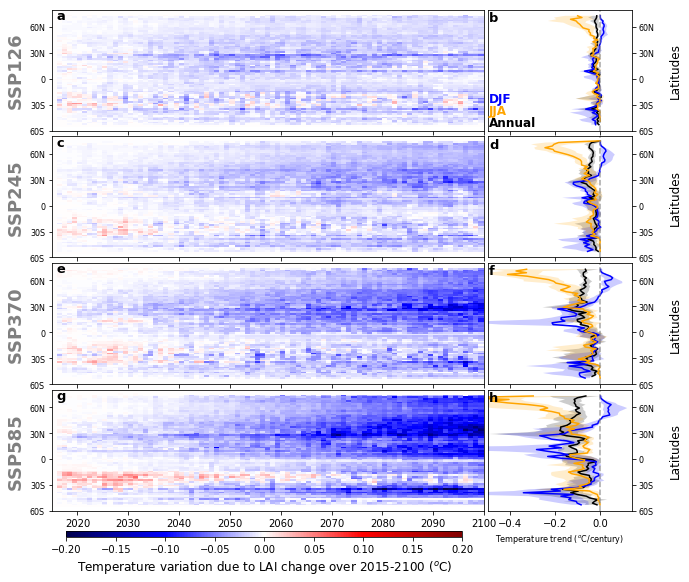

In [13]:
"""

  Extrapolate the sensitivity to Future SSPs CMIP6 data 

"""
def readzonal(v):
  V_DJF=zonaltrend(N.mean(((v[11::12,:,:]+v[0::12,:,:]+v[1::12,:,:])/3.),axis=2))
  V_JJA=zonaltrend(N.mean(((v[5::12,:,:]+v[6::12,:,:]+v[7::12,:,:])/3.),axis=2))
  # to annual
  for mm_ in range(12):
    if mm_==0:
      V_=v[mm_::12,:,:]/12.
    else:
      V_=V_+v[mm_::12,:,:]/12.    
  V_=N.mean(V_,axis=2)
  V_=V_[:,:]-V_[0,:] #relative to the first year
  return V_,V_DJF,V_JJA

def zonaltrend(v_):
 TREND=[]
 for kk in range(v_.shape[1]):
   trend, intercept, r_value, p_value, std_err =stats.linregress(range(v_.shape[0]),v_[:,kk])
   TREND.append(trend)
 return N.array(TREND)

plot_fig3=True
if plot_fig3:
 for ssp in [126,245,370,585]:
  files_dT_dLai=glob.glob('*_dT_dLAI_ssp%i_201501_210012.nc'%ssp)
  for vvaarr in ['dT','dT_dLAI']:
     for tim in ['DJF','JJA']:
        vars()['%s_%s%i'%(vvaarr,tim,ssp)]=N.zeros((len(files_dT_dLai),68))
     vars()['%s_ANNUAL%i'%(vvaarr,ssp)]=N.zeros((len(files_dT_dLai),86,68))
  ii=-1
  for fil in files_dT_dLai:
    ii=ii+1
    model=fil[:-32]
    if not os.path.exists('/ESS_Datasets/EXT_ESM/CMIP6/Historical/SE/lai_%s_SE.nc'%model):
            print 'historical %s ssp%s does not exist, please download it'%(model,ssp)
    else:
            for vv in ['lai','snc','evspsbl','rsds']: # read SE historical files
                f=cdms.open('/ESS_Datasets/EXT_ESM/CMIP6/Workdir/%s_%s_ssp%i_201501-210012.nc'%(vv,model,ssp))
                vars()[vv]=f(vv,lat=latrange,lon=lonrange)
                f.close()
                f=cdms.open('/ESS_Datasets/EXT_ESM/CMIP6/Historical/SE/%s_%s_SE.nc'%(vv,model))
                vars()[vv+'0']=f(vv,lat=latrange,lon=lonrange)
                f.close()
                vars()[vv+'0']=repeat_first_yearsMean(eval(vv+'0'), eval(vv))  
            ratio_evap=MV.where(evspsbl0<=0.,1,evspsbl/evspsbl0)
            ratio_evap=MV.where(ratio_evap<0,0,ratio_evap)     # never hapen but just in case of corupted gridcell
            # 1) all Bioph
            dT_allBioph3D=dT_function3D(lai0,lai,rsds,evspsbl0,snc,ratio_evap,True)
            yaxe=dT_allBioph3D[0].getLatitude()[:]
            dT_annual,dT_djf,dT_jja=readzonal(dT_allBioph3D[0])
            dT_dLAI_annual,dT_dLAI_djf,dT_dLAI_jja=readzonal(dT_allBioph3D[1])            
            for vvaarr in ['dT','dT_dLAI']:
              for tim in ['DJF','JJA']:
                eval('%s_%s%i'%(vvaarr,tim,ssp))[ii,:]=eval('%s_%s'%(vvaarr,tim.lower()))[:]
              eval('%s_ANNUAL%i'%(vvaarr,ssp))[ii,:,:]=eval('%s_annual'%vvaarr)[:,:]
    
# ------------------------------------------------ #
 # --------------------------------------------- #
  #     Latitude-Time  sensitivity Plot         #
 # --------------------------------------------- #
# ------------------------------------------------ #

 for var in ['dT']: #'dT_constCLIMATE'
  fig = plt.figure(figsize=(10,8))
  jj=0
  if var =='dT' :VMIN,VMAX=-0.2,0.2
  if var =='dT_dLAI' :VMIN,VMAX=-0.1,0.1
  for ssp in [126,245,370,585]:
   jj=jj+1
   res=eval('%s_ANNUAL%i'%(var,ssp))   
   VT_DJF,VT_JJA=eval('%s_DJF%i'%(var,ssp)),eval('%s_JJA%i'%(var,ssp))
   VT=N.zeros((res.shape[0],68))
   for ii in range(res.shape[0]):
    zon=zonaltrend(res[ii,:,:])
    VT[ii,:]=zon[:]

   if jj==1:X1,Y1=0.1,0.77
   if jj==3:X1,Y1=0.1,0.55
   if jj==5:X1,Y1=0.1,0.33
   if jj==7:X1,Y1=0.1,0.11

   zon=N.percentile(res,50,axis=0)
   ax = fig.add_axes([X1,Y1,0.6,0.21])#fig.add_subplot(4,1,jj)
   ax.text(0.01, 0.9, dicleb[jj], verticalalignment='bottom', horizontalalignment='left', \
           transform=ax.transAxes, color='black', fontsize=13,fontweight='bold') 

   p = ax.pcolor(N.arange(2015,2101,1),N.arange(-55,80,2), zon.T, cmap=plt.cm.seismic, vmin=VMIN, vmax=VMAX)
   ax.yaxis.set_major_locator(MultipleLocator(30))
   plt.ylim((-60, 80))
   setoff=ax.get_yticks().tolist()
   for nn in range(len(setoff)): 
      if setoff[nn]<-0.1:
        setoff[nn]=str(abs(int( setoff[nn])))+'S'
      elif setoff[nn]>0.1:
        setoff[nn]=str(int( setoff[nn]))+'N'
      else:
        setoff[nn]='0'
   ax.set_yticklabels(setoff,fontsize=8)
  
   if jj<7:
    setoffx=ax.get_xticks().tolist()
    for nn in range(len(setoffx)): 
        setoffx[nn]=''
    ax.set_xticklabels(setoffx)

   if ssp==585:
      fig.subplots_adjust(bottom=0.05)
      cbar_ax = fig.add_axes([0.12, 0.065, 0.55, 0.01])
      cbar=fig.colorbar(p, cax=cbar_ax,orientation='horizontal')
      #cbar_ax = fig.add_axes([0.8, 0.1, 0.01, 0.7])
      #cbar=fig.colorbar(im, cax=cbar_ax,orientation='vertical')
      if var =='dT_dLAI':cbar.set_label(r'dT/dLAI over 2015-2100 ($^o$C/m$^2$/m$^2$)',fontsize=12)
      if var =='dT':     cbar.set_label(r'Temperature variation due to LAI change over 2015-2100 ($^o$C)',fontsize=12)

   ax.set_ylabel('SSP%i'%(ssp), color='grey', fontsize=18,fontweight='bold')

   jj=jj+1
   if jj==2:X1,Y1=0.705,0.77
   if jj==4:X1,Y1=0.705,0.55
   if jj==6:X1,Y1=0.705,0.33
   if jj==8:X1,Y1=0.705,0.11

   ax = fig.add_axes([X1,Y1,0.2,0.21])
   ax.text(0.01, 0.99, dicleb[jj], verticalalignment='top', horizontalalignment='left', \
           transform=ax.transAxes, color='black', fontsize=13,fontweight='bold') 
   if jj==2:
    ax.text(0.01, 0.01, 'Annual', verticalalignment='bottom', horizontalalignment='left',
          transform=ax.transAxes, color='black', fontsize=12,fontweight='bold')
    ax.text(0.01, 0.11, 'JJA', verticalalignment='bottom', horizontalalignment='left',
          transform=ax.transAxes, color='orange', fontsize=12,fontweight='bold')
    ax.text(0.01, 0.21, 'DJF', verticalalignment='bottom', horizontalalignment='left',
          transform=ax.transAxes, color='blue', fontsize=12,fontweight='bold')

   colors={'VT':'black','VT_DJF':'blue','VT_JJA':'orange'}
   for vvar in ['VT','VT_DJF','VT_JJA']:
    vars()[vvar]=MV.masked_greater(eval(vvar),1.e10)
    vars()[vvar]=MV.masked_equal(eval(vvar),0.)
    vars()[vvar+'min'] =MV.masked_equal(N.percentile(eval(vvar),25, axis=0),0)*100
    vars()[vvar+'max'] =MV.masked_equal(N.percentile(eval(vvar),75, axis=0),0)*100
    vars()[vvar+'mean']=MV.masked_equal(N.percentile(eval(vvar),50, axis=0),0)*100
    YAXE=yaxe*(eval(vvar+'min')/eval(vvar+'min'))
    YAXE=YAXE*(eval(vvar+'max')/eval(vvar+'max'))
    YAXE=YAXE*(eval(vvar+'mean')/eval(vvar+'mean'))
    vars()[vvar+'min']=eval(vvar+'min')*(YAXE/YAXE)
    vars()[vvar+'max']=eval(vvar+'max')*(YAXE/YAXE)
    vars()[vvar+'mean']=eval(vvar+'mean')*(YAXE/YAXE)
    ax.fill_betweenx(YAXE.compressed(), eval(vvar+'min').compressed(), eval(vvar+'max').compressed(),facecolor=colors[vvar],alpha=0.2,lw=0)
    ax.plot(eval(vvar+'mean').compressed(),YAXE.compressed(), colors[vvar] , linewidth=1.5)

   ax.set_ylabel('Latitudes',fontsize=12)
   
   ax.yaxis.tick_right()
   ax.yaxis.set_major_locator(MultipleLocator(30))
   plt.ylim((-60, 80))
   plt.plot([0,0],[-60,80], linestyle ='--',color='grey',alpha=0.7)
   setoff=ax.get_yticks().tolist()
   for nn in range(len(setoff)): 
      if setoff[nn]<-0.1:
        setoff[nn]=str(abs(int( setoff[nn])))+'S'
      elif setoff[nn]>0.1:
        setoff[nn]=str(int( setoff[nn]))+'N'
      else:
        setoff[nn]='0'
   ax.set_yticklabels(setoff,fontsize=8)
   ax.yaxis.tick_right()
   ax.yaxis.set_label_coords(1.35, 0.5)
   if var=='dT_dLAI': 
    plt.xlim((-0.199, 0.039))
    ax.xaxis.set_major_locator(MultipleLocator(0.05))
    if jj==8:ax.set_xlabel(r'dT/dLAI trend ($^o$C/m$^2$/m$^2$/century)',fontsize=8)
   if var=='dT': 
    plt.xlim((-0.499, 0.139))
    ax.xaxis.set_major_locator(MultipleLocator(0.2))
    if jj==8:ax.set_xlabel(r'Temperature trend ($^o$C/century)',fontsize=8)

  plt.savefig('Figure_03_%s.pdf'%var, dpi=300, bbox_inches="tight")
  
